In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pywt
import os
import sys
from importlib import reload
from pyedflib import highlevel
from scipy.signal import butter, lfilter

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import (
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    accuracy_score,
    f1_score,
)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Подгружаем пути к директориям с нашими алгоритмами:
script_path = os.path.join(os.getcwd(), "../../Scripts/")
sys.path.append(script_path)
import data_generator as dgen
import features as ft

In [42]:
dgen.init(filter=True)
amy, amyc, norm, amy_h, amyc_h, norm_h = dgen.read_data_with_meta()

In [43]:
norm_parts = dgen.crop(norm)
amy_parts = dgen.crop(amy)
amyc_parts = dgen.crop(amyc)

Изучим общее количество фрагментов для каждого класса

In [44]:
print(len(norm_parts), "- Norm parts")
print(len(amy_parts), "- amy parts")
print(len(amyc_parts), "- amyc parts")

norm_parts = np.array(norm_parts)
amy_parts = np.array(amy_parts)
amyc_parts = np.array(amyc_parts)

102 - Norm parts
74 - amy parts
62 - amyc parts


In [45]:
def extract_statistical_features(ecg_signal):
    features = {}
    features["std"] = pd.Series(np.std(ecg_signal, axis=1))
    features["min"] = pd.Series(np.min(ecg_signal, axis=1))
    features["max"] = pd.Series(np.max(ecg_signal, axis=1))
    features["range"] = pd.Series(np.ptp(ecg_signal, axis=1))  # max - min
    return features


def extract_frequency_features(ecg_signal):
    # Преобразование Фурье
    fft = np.fft.fft(ecg_signal)
    fft_mag = np.abs(fft)

    # Извлекаем частотные признаки
    features = {}
    features["freq_std"] = pd.Series(np.std(fft_mag, axis=1))
    features["freq_max"] = pd.Series(np.max(fft_mag, axis=1))

    return features


def extract_wavelet_features(ecg_signal):
    coeffs = pywt.wavedec(ecg_signal, "db4", level=4)
    features = {}

    # Извлечение статистики для каждого уровня
    for i, coeff in enumerate(coeffs):
        features[f"wavelet_std_level_{i}"] = pd.Series(np.std(coeff, axis=1))

    return features

А теперь поделим данные на трейн тест по людям, и после порежем сигналы на части

In [82]:
import pickle

with open("../../Data/dumped/X_train.pkl", "rb") as f:
    f.seek(0)
    X_train = pickle.load(f)
with open("../../Data/dumped/y_train.pkl", "rb") as f:
    f.seek(0)
    y_train = pickle.load(f)
with open("../../Data/dumped/X_test.pkl", "rb") as f:
    f.seek(0)
    X_test = pickle.load(f)
with open("../../Data/dumped/y_test.pkl", "rb") as f:
    f.seek(0)
    y_test = pickle.load(f)

print(X_train.shape)
print(y_train.shape)
Y_train = y_train[0].astype("int8")
Y_test = y_test[0].astype("int8")

(132, 8, 5000)
(2, 132)


In [47]:
# data_raw = norm + amyc + amy

# data_raw = [row[0] for row in data_raw]
# #data_raw = norm + amy
# lab = np.concatenate([np.zeros(len(norm) + len(amyc)), np.ones(len(amy))])
# #lab = np.concatenate([np.zeros(len(norm)), np.ones(len(amy))])
# X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(data_raw, lab, test_size=0.2, random_state=42)

# data_train = []
# y_train = []
# data_test = []
# y_test = []

# for i in range(len(X_train_raw)):
#     temp = dgen.crop([X_train_raw[i]])
#     data_train.extend(temp)
#     y_train.extend(y_train_raw[i] * np.ones(len(temp)))

# for i in range(len(X_test_raw)):
#     temp = dgen.crop([X_test_raw[i]])
#     data_test.extend(temp)
#     y_test.extend(y_test_raw[i] * np.ones(len(temp)))

# data_train = np.array(data_train)
# y_train = np.array(y_train)
# data_test = np.array(data_test)
# y_test = np.array(y_test)

In [83]:
data_train = [signal[0] for signal in X_train]
data_test = [signal[0] for signal in X_test]

In [84]:
X_train = pd.DataFrame(
    {
        **extract_statistical_features(data_train),
        **extract_frequency_features(data_train),
        **extract_wavelet_features(data_train),
    }
)
X_test = pd.DataFrame(
    {
        **extract_statistical_features(data_test),
        **extract_frequency_features(data_test),
        **extract_wavelet_features(data_test),
    }
)

# Классификатор Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, Y_train)

# Оценка точности
y_pred = rf.predict(X_test)
print(f"Random Forest accuracy: {accuracy_score(Y_test, y_pred)}")

# Классификатор SVM
svm = SVC()
svm.fit(X_train, Y_train)
y_pred_svm = svm.predict(X_test)
print(f"SVM accuracy: {accuracy_score(Y_test, y_pred_svm)}")

Random Forest accuracy: 0.6875
SVM accuracy: 0.6458333333333334


In [50]:
X_train.head()

,std,min,max,range,freq_std,freq_max,wavelet_std_level_0,wavelet_std_level_1,wavelet_std_level_2,wavelet_std_level_3,wavelet_std_level_4
0,0.328591,-1.909962,0.177739,2.087701,23.845282,617.773527,1.273859,0.434707,0.091706,0.012003,0.002282
1,0.752885,-3.009595,0.200324,3.209919,73.282932,3592.333004,3.002934,0.147576,0.031303,0.010837,0.003123
2,0.358826,-1.741256,1.390972,3.132229,24.544805,347.091528,1.317433,0.498166,0.150169,0.025601,0.002672
3,0.214637,-1.150223,0.618360,1.768583,25.347234,1472.024098,0.832016,0.251883,0.072430,0.019766,0.004491
4,0.178344,-0.854593,1.117024,1.971617,21.342560,1256.328981,0.636713,0.277056,0.111904,0.029570,0.004716


Простая важность

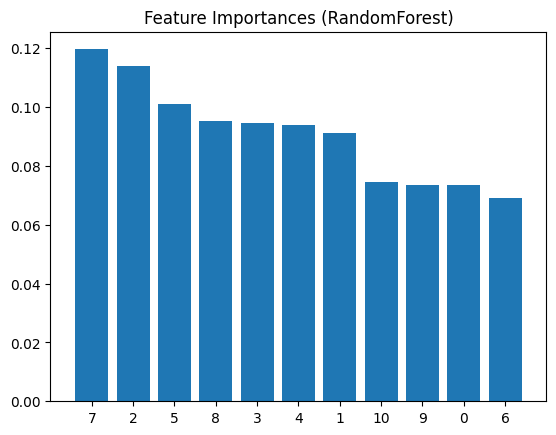

Feature 7: 0.11965806527031374
Feature 2: 0.11383526740796177
Feature 5: 0.10112905090248617
Feature 8: 0.0951427757431
Feature 3: 0.09470107304068137
Feature 4: 0.0939998096272224
Feature 1: 0.09120780825818973
Feature 10: 0.07461339596787346
Feature 9: 0.073355998999378
Feature 0: 0.07335378478037538
Feature 6: 0.069002970002418


In [51]:
# Получение важности признаков
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

# Визуализация важности признаков
plt.figure()
plt.title("Feature Importances (RandomForest)")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

# Вывод важности признаков
for i in range(X_train.shape[1]):
    print(f"Feature {indices[i]}: {importances[indices[i]]}")

Permutation importance

In [52]:
from sklearn.inspection import permutation_importance

# Оценка перестановочной важности признаков
perm_importance = permutation_importance(
    rf, X_train, y_train, n_repeats=100, random_state=42
)

# Получение важности и сортировка
indices = np.argsort(perm_importance.importances_mean)[::-1]

# Вывод важности признаков
for i in range(X_train.shape[1]):
    print(f"Feature {indices[i]}: {perm_importance.importances_mean[indices[i]]}")

TypeError: '<' not supported between instances of 'dict' and 'float'

SHAP Values (SHapley Additive exPlanations)

(5397, 11)


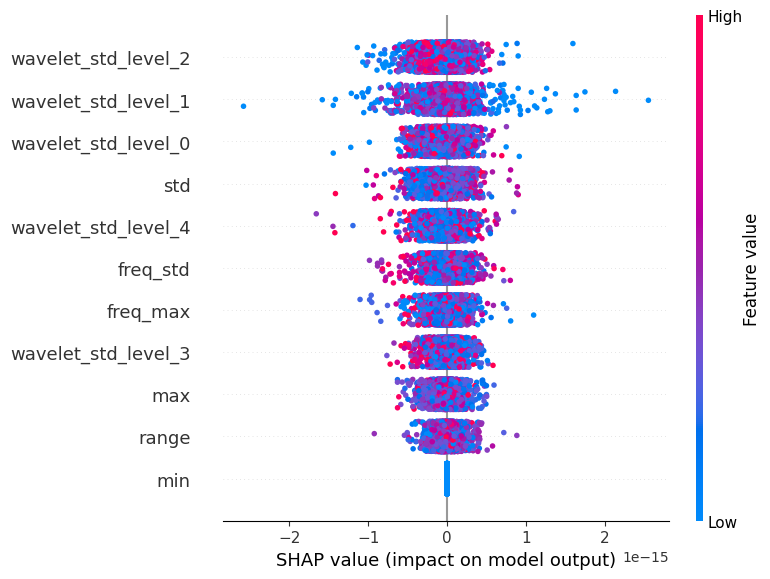

In [23]:
import shap

# Создание объекта SHAP explainer
explainer = shap.TreeExplainer(rf)

# Получение SHAP values
shap_values = explainer.shap_values(X_train)


# Визуализация важности признаков
# shap.summary_plot(shap_values, X_train, plot_size=(12, 8))
# Для бинарной классификации можно усреднить SHAP values
mean_shap_values = np.mean(shap_values, axis=2)
print(mean_shap_values.shape)
shap.summary_plot(mean_shap_values, X_train)

Voting accuracy: 0.7291666666666666

 clasification report:
               precision    recall  f1-score   support

           0       0.91      0.75      0.82        40
           1       0.33      0.62      0.43         8

    accuracy                           0.73        48
   macro avg       0.62      0.69      0.63        48
weighted avg       0.81      0.73      0.76        48

Матрица несоответствий для тестовой выборки метода ЛДА:



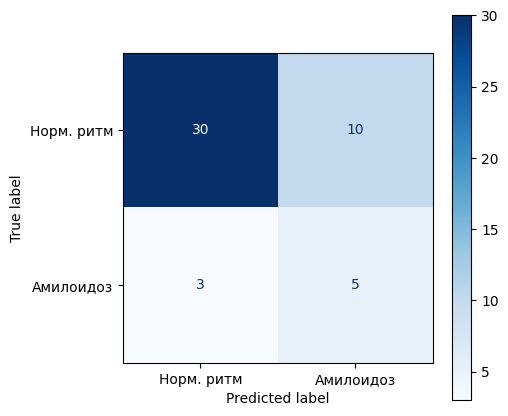

In [85]:
# Создание нескольких классификаторов
rf = RandomForestClassifier(criterion="log_loss")
svm = SVC(probability=True)
# Добавим классификаторы в ансамбль
voting_clf = VotingClassifier(estimators=[("rf", rf), ("svm", svm)], voting="soft")

# Обучение ансамбля
voting_clf.fit(X_train, Y_train)

# Оценка точности
y_pred_voting = voting_clf.predict(X_test)
print(f"Voting accuracy: {accuracy_score(Y_test, y_pred_voting)}")

# Замените названия классов на соответствующие вам
class_names = ["Норм. ритм", "Амилоидоз"]

print("\n clasification report:\n", classification_report(Y_test, y_pred_voting))

print("Матрица несоответствий для тестовой выборки метода ЛДА:\n")
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix(Y_test, y_pred_voting), display_labels=class_names
)
disp.plot(cmap="Blues", ax=ax)

# Пробуем с готовыми фичами Зины



In [33]:
with open("../../Data/dumped/X_train_fraction_train_2.pkl", "rb") as f:
    f.seek(0)
    X_train = pickle.load(f)
with open("../../Data/dumped/y_train_fraction_train_2.pkl", "rb") as f:
    f.seek(0)
    y_train = pickle.load(f)
with open("../../Data/dumped/X_test_fraction_test_2.pkl", "rb") as f:
    f.seek(0)
    X_test = pickle.load(f)
with open("../../Data/dumped/y_test_fraction_test_2.pkl", "rb") as f:
    f.seek(0)
    y_test = pickle.load(f)

features_train = ft.extract_features(X_train, y_train[1])
features_train = features_train.fillna(0)

features_test = ft.extract_features(X_test, y_test[1])
features_test = features_test.fillna(0)

X_train = features_train
X_test = features_test
y_train = y_train[0]
y_test = y_test[0]


# Классификатор Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Оценка точности
y_pred = rf.predict(X_test)
print(f"Random Forest accuracy: {accuracy_score(y_test, y_pred)}")

# Классификатор SVM
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print(f"SVM accuracy: {accuracy_score(y_test, y_pred_svm)}")

/home/kravchenko.artem/Projects/Diplomas/.venv/lib/python3.10/site-packages/neurokit2/signal/signal_period.py:84: NeuroKitWarning: Too few peaks detected to compute the rate. Returning empty vector.
  warn(


Ошибка при обработке сигнала 86: cannot convert float NaN to integer
Ошибка при обработке сигнала 604: '[5008] not in index'


ValueError: Found input variables with inconsistent numbers of samples: [906, 908]

(180, 12)


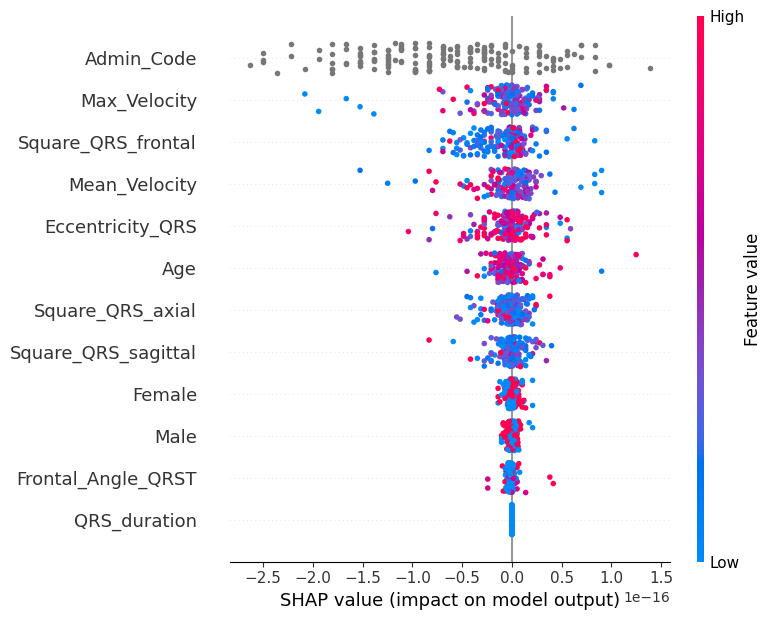

In [14]:
import shap

# Создание объекта SHAP explainer
explainer = shap.TreeExplainer(rf)

# Получение SHAP values
shap_values = explainer.shap_values(X_train)


# Визуализация важности признаков
# shap.summary_plot(shap_values, X_train, plot_size=(12, 8))
# Для бинарной классификации можно усреднить SHAP values
mean_shap_values = np.mean(shap_values, axis=2)
print(mean_shap_values.shape)
shap.summary_plot(mean_shap_values, features_train)

Voting accuracy: 0.7391304347826086

 clasification report:
               precision    recall  f1-score   support

         0.0       0.73      1.00      0.85        33
         1.0       1.00      0.08      0.14        13

    accuracy                           0.74        46
   macro avg       0.87      0.54      0.49        46
weighted avg       0.81      0.74      0.65        46

Матрица несоответствий для тестовой выборки метода ЛДА:



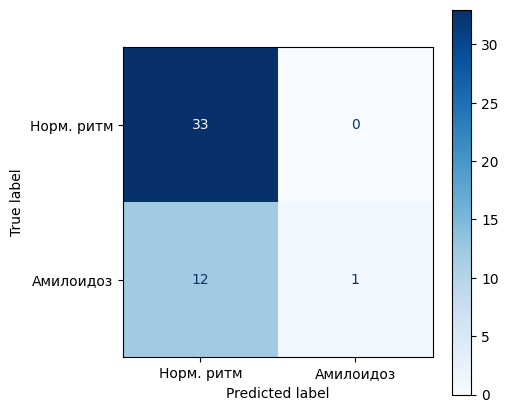

In [15]:
# Создание нескольких классификаторов
rf = RandomForestClassifier(criterion="log_loss")
svm = SVC(probability=True)
# Добавим классификаторы в ансамбль
voting_clf = VotingClassifier(estimators=[("rf", rf), ("svm", svm)], voting="soft")

# Обучение ансамбля
voting_clf.fit(X_train, y_train)

# Оценка точности
y_pred_voting = voting_clf.predict(X_test)
print(f"Voting accuracy: {accuracy_score(y_test, y_pred_voting)}")

# Замените названия классов на соответствующие вам
class_names = ["Норм. ритм", "Амилоидоз"]

print("\n clasification report:\n", classification_report(y_test, y_pred_voting))

print("Матрица несоответствий для тестовой выборки метода ЛДА:\n")
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_voting), display_labels=class_names
)
disp.plot(cmap="Blues", ax=ax)

In [26]:
signal_len = dgen.signal_len
normalize = dgen.normalize


def calcGroupTable(
    model, groupnames: list, records: list, label: int, df: pd.DataFrame, metadata
):
    for i in range(len(groupnames)):
        record = records[i]
        #        y_pred = model.predict(pd.DataFrame({**extract_statistical_features(parts), **extract_frequency_features(parts), **extract_wavelet_features(parts)}))
        #        y_weighted = np.asarray(y_pred).sum() / len(y_pred)

        #        y_weighted = round(y_weighted)
        features = ft.extract_features([record], [metadata[i]])
        features = features.fillna(0)
        y_pred = model.predict(features)
        y_pred = int(y_pred[0])

        df.loc[-1] = [groupnames[i], y_pred, label]
        df.index = df.index + 1
        df = df.sort_index()
    return df

In [27]:
# There are two classes. 0 - norm, 1 - amy

pred_tab = pd.DataFrame(columns=["name", "weighted_predict", "label"])

norm_names = os.listdir(dgen.norm_path)
amy_names = os.listdir(dgen.amy_path)
amyc_names = os.listdir(dgen.amyc_path)

norm_names = [name[:6] + "_norm" + name[6:] for name in norm_names]

pred_tab = calcGroupTable(voting_clf, norm_names, norm, 0, pred_tab, norm_h)
pred_tab = calcGroupTable(voting_clf, amyc_names, amyc, 0, pred_tab, amyc_h)
pred_tab = calcGroupTable(voting_clf, amy_names, amy, 1, pred_tab, amy_h)


pred_tab.head(5)

pred_tab.to_csv("voted_result.csv", index=False)